In [26]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [51]:
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [28]:
# connect drive
moon_data = pd.read_csv("drive/My Drive/PROJ S/Train_Test_data/Moon2x.csv")
moon_data.head()

,Unnamed: 0,Time,Right Ascension,Declination,Distance,X,Y,Z
0,0,2019-11-02 00:00:00.000000000,282.159899,-23.839308,384757.021309,74130.881791,-344034.483716,-155508.365773
1,1,2019-11-02 00:08:13.761310601,282.209434,-23.837778,384815.329210,74440.443967,-344026.450869,-155522.535344
2,2,2019-11-02 00:16:27.522621202,282.259143,-23.835818,384879.579637,74752.500679,-344024.368148,-155536.454196
3,3,2019-11-02 00:24:41.283931803,282.309065,-23.833429,384949.733058,75067.284738,-344028.136987,-155550.122805
4,4,2019-11-02 00:32:55.045242404,282.359237,-23.830615,385025.742595,75385.025251,-344037.650472,-155563.541637


In [29]:
xyz = moon_data[['X', 'Y', 'Z']].to_numpy()
xyz[:5]

array([[  74130.88179102, -344034.48371644, -155508.36577318],
       [  74440.4439674 , -344026.45086866, -155522.53534387],
       [  74752.50067854, -344024.36814838, -155536.45419649],
       [  75067.28473816, -344028.13698713, -155550.12280523],
       [  75385.02525141, -344037.65047191, -155563.5416375 ]])

In [30]:
pca = PCA(n_components=2)
pca.fit(xyz)
lower_dim_xy = pca.transform(xyz)
#this has our x' and y', which are equivalent to 
# a cos (theta) and b sin (theta)
lower_dim_xy[:5]
lower_dim_xyt = np.array([np.append(lower_dim_xy[i], i) for i in range(lower_dim_xy.shape[0])])

In [31]:
# These are approximately perpendicular unit vectors 
# (since our data shows that the path is approximately an ellipse)
print(pca.components_)
print(np.dot(pca.components_[0], pca.components_[1]))
print(lower_dim_xyt[:5])

[[-0.71994811  0.6127415   0.32591806]
 [-0.68823159 -0.69088278 -0.22140068]]
-8.326672684688674e-17
[[-2.62441613e+05  2.35186726e+05  0.00000000e+00]
 [-2.62664177e+05  2.34971263e+05  1.00000000e+00]
 [-2.62892102e+05  2.34758138e+05  2.00000000e+00]
 [-2.63125495e+05  2.34547124e+05  3.00000000e+00]
 [-2.63364454e+05  2.34337989e+05  4.00000000e+00]]


Find major and minor axis of ellipse through regression 

In [32]:
def linear_regress_ellipse(two_dim_inp):
  ones = np.ones((two_dim_inp.shape[0], 1))
  phi = two_dim_inp ** 2
  print(two_dim_inp.shape)
  print(ones.shape)
  coef = np.linalg.inv(phi.T @ phi) @ phi.T @ ones
  return coef

In [33]:
coef = linear_regress_ellipse(lower_dim_xyt)
a = np.sqrt(1/coef[0])
b = np.sqrt(1/coef[1])
print(a, b)


(10500, 3)
(10500, 1)
[397456.12867084] [389164.20762901]


[https://www.petercollingridge.co.uk/tutorials/computational-geometry/finding-angle-around-ellipse/](dfash)




Fit theta to timestep as sin function with major ellipse axis as amplitude. Insert ptolemy justification here to have constant angular velocity instead of Kepler's angular velocity law which came after



In [34]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_amp = np.std(yy) * 2.**0.5
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

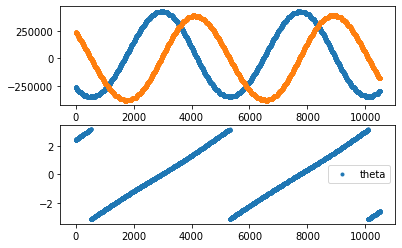

In [35]:
# Plot 2d data with time step as sin wave
x_ = lower_dim_xyt[:,0]
y_ = lower_dim_xyt[:,1]
t_ = lower_dim_xyt[:,2]

theta = np.arctan2(y_,x_)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(t_, x_, '.',label='x')
ax1.plot(t_, y_, '.', label='y')
ax2.plot(t_, theta, '.', label='theta')
plt.legend()
plt.show()

In [82]:
x_ = lower_dim_xyt[:,0]
y_ = lower_dim_xyt[:,1]
t_ = lower_dim_xyt[:,2]

theta = np.arctan2(y_,x_)
eps = 1e-3
neg_eps = -1 * eps
zero_idx = np.argwhere((theta < eps) & (theta > neg_eps))
zero_idx

array([[2969],
       [7721]])

In [192]:
theta[0]

2.4109093869530667

theta = 

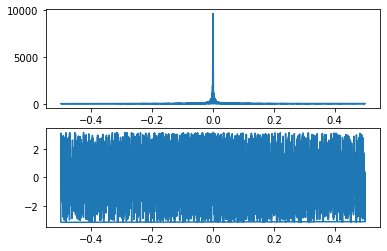

In [36]:
dft = np.fft.fft(theta)
freq = np.fft.fftfreq(len(theta), t_[1] - t_[0])

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(freq, np.abs(dft))
ax2.plot(freq, np.angle(dft))
plt.show()

In [ ]:
idx = np.argmax(abs(dft))
print(idx)
peak_f = abs(freq[idx])
print(peak_f)
peak_period = 1/peak_f
print(peak_period)
n = theta.shape[0]

ps = abs(dft[0:int(n/2)])**2/n
sorted_fourier = np.sort(ps.flatten())[::-1]
top_fourier = sorted_fourier[:15]
print(top_fourier)
freqs = [list(ps).index(i) for i in list(top_fourier)]
fourier = dft[freqs]
print(freqs)

for f in freqs:
  peak_f = abs(freq[f])
  print(peak_f)
  peak_period = 1/peak_f
  print(peak_period)
  n = theta.shape[0]



In [88]:
x_period = fit_sin(t_, x_)['period']
y_period = fit_sin(t_, y_)['period']
avg_period_theta = (x_period + y_period) / 2
print(f'Average period in timesteps: {avg_period}')
# Now our functions for x' and y' are acos(t/avg_period + c) and bsin(t/avg_period + c)

Average period in timesteps: 4803.613650585232


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [124]:
try:
  t0 = datetime.strptime(moon_data['Time'][0],'%Y-%m-%d %H:%M:%S.%f')
except ValueError:
  print(moon_data['Time'][0].split('.')[0])
  t0 = datetime.strptime(moon_data['Time'][0].split('.')[0],'%Y-%m-%d %H:%M:%S')

t1 = datetime.strptime(moon_data['Time'][1][:-3],'%Y-%m-%d %H:%M:%S.%f')
print(f't0: {t0}')
timestep = t1 - t0
print(timestep)
print(timestep.total_seconds())
avg_period_seconds = avg_period_theta * timestep.total_seconds()
print(f'Average period in seconds: {avg_period_seconds}')

standard_step = zero_idx[0][0]
print(type(standard_step))
new_timestep = (standard_step * timestep)
print(type(new_timestep))
standard_time = t0 + (standard_step * timestep)
print(type(t0))
print(type(timestep))
print(standard_time)
print(type(standard_time))

2019-11-02 00:00:00
t0: 2019-11-02 00:00:00
0:08:13.761310
493.76131
Average period in seconds: 2371838.5688468465
<class 'numpy.int64'>
<class 'datetime.timedelta'>
<class 'datetime.datetime'>
<class 'datetime.timedelta'>
2019-11-18 23:12:57.329390
<class 'datetime.datetime'>


In [190]:
def linear_regress_ellipse(two_dim_inp):
  ones = np.ones((two_dim_inp.shape[0], 1))
  phi = two_dim_inp ** 2
  #print(two_dim_inp.shape)
  #print(ones.shape)
  coef = np.linalg.inv(phi.T @ phi) @ phi.T @ ones
  return coef

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_amp = np.std(yy) * 2.**0.5
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

class MoonPredictor:
  def __init__(self):
    self.sample_time = "2019-11-02 00:00:00"
    self.timestep = None
    self.standard_time = None
    self.cycle_period = 0
    self.cycle_period_s = 0
    self.a = 0
    self.b = 0
    self.major_axis = None
    self.minor_axis = None
    
  def fit(self, moon_data):
    #updates timestep, standard_time, cycle_period
    #Get major and minor axes
    pca = PCA(n_components=2)
    pca.fit(xyz)
    lower_dim_xy = pca.transform(xyz)
    self.major_axis = pca.components_[0]
    self.minor_axis = pca.components_[1]
    lower_dim_xyt = np.array([np.append(lower_dim_xy[i], i) for i in range(lower_dim_xy.shape[0])])
    
    #Get a and b
    coef = linear_regress_ellipse(lower_dim_xyt)
    self.a = np.sqrt(1/coef[0])
    self.b = np.sqrt(1/coef[1])

    #Get standard cycle values
    x_ = lower_dim_xyt[:,0]
    y_ = lower_dim_xyt[:,1]
    t_ = lower_dim_xyt[:,2]

    theta = np.arctan2(y_,x_)
    eps = 1e-3
    neg_eps = -1 * eps
    zero_idx = np.argwhere((theta < eps) & (theta > neg_eps))
    x_period = fit_sin(t_, x_)['period']
    y_period = fit_sin(t_, y_)['period']
    self.cycle_period = (x_period + y_period) / 2

    t0 = datetime.strptime(moon_data['Time'][0][:-3],'%Y-%m-%d %H:%M:%S.%f')
    t1 = datetime.strptime(moon_data['Time'][1][:-3],'%Y-%m-%d %H:%M:%S.%f')
    print(f't0: {t0}')
    self.timestep = t1 - t0
    print(f'timestep seconds: {self.timestep.total_seconds()}')
    self.cycle_period_s = self.cycle_period * self.timestep.total_seconds()
    print(f'Average period in seconds: {self.cycle_period_s}')

    standard_step = zero_idx[0][0]
    self.standard_time = t0 + standard_step * self.timestep
    pass

  def predict_position(self, time = sim.sample_time):
    try: 
      pred_time = datetime.strptime(time,'%Y-%m-%d %H:%M:%S.%f')
    except ValueError:
      pred_time = datetime.strptime(time.split('.')[0], '%Y-%m-%d %H:%M:%S')
    time_delta = (pred_time - self.standard_time)
    print(f'td: {time_delta.total_seconds()}')
    time_delta = time_delta.total_seconds() % self.cycle_period_s
    print(f'td: {time_delta}')
    theta = (time_delta / self.cycle_period_s) * (2 * np.pi)
    print(f'theta: {theta}')
    xp = a * np.cos(theta)
    yp = b * np.sin(theta)
    xyz = xp * self.major_axis + yp * self.minor_axis
    
    return xyz
  
  def predict_phase(self, time):
    pass

In [191]:
sim = MoonPredictor()
sim.fit(moon_data)
sim.predict_position("2019-11-18 00:12:57.329390")
sim.predict_position()

t0: 2019-11-02 00:00:00
timestep seconds: 493.76131
Average period in seconds: 2371838.5687311604
td: -82800.0
td: 2289038.5687311604
theta: 6.063841651041647
td: -1465977.32939
td: 905861.2393411603
theta: 2.399697055443659


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([  29972.44337653, -361203.15935794, -153712.06643812])

## Neural Net time 
### Gradient Descent to fit sawtooth 